## Результаты классификаторов и статистическая значимость

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt

import os
import numpy as np
import pandas as pd
import scipy
import torch

import helpers

from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('precision', 3)

bus_class_scores_df = helpers.get_serialized_models_scores()
bus_class_scores_df = bus_class_scores_df.sort_values(by=['F1 test', 'F1 train'], ascending=False)
bus_class_scores_df[['Classifier', 'F1 test', 'F1 train']]

,Classifier,F1 test,F1 train
1,BOW One-hot + XGBoost,0.944,0.956
2,Embeddings + RNN(E-256 R-32 B-128),0.933,0.949
0,BOW One-hot + LR (baseline),0.916,0.940


Проверим результаты трех полученных классификаторов формально с помощью математической статистики. Необходимо убедиться, что Gradient Boosting на BOW статистически значимо лучше других двух, т.е. результаты получены неслучайно.

На каждом классификаторе мы посчитали значение статистики $F1 score$.
$F1 score$ - есть случайная величина из неизвестного нам теоретического распределения $P$.

Попробуем эмпирически оценить распределение $P$ с помощью метода Бутстреп(семплирование с возвращением).

In [3]:
def get_bootstrap_samples(data, num_samples):
    indices = np.random.randint(0, len(data), (num_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

## Доверительные интервалы

Сначала построим доверительные интервалы для $F1score$ для каждого из классификаторов.

### Logistic Regression классификатор (baseline)

In [4]:
test_dataset = np.array(list(helpers.load_one_hot_test_dataset()))
lr_model = helpers.load_model('lr_model')

f1_lr = []
for x in get_bootstrap_samples(test_dataset, 1000):
    data_points, answers = list(zip(*x))
    y_test_pred = lr_model.predict(data_points)
    f1_lr.append(f1_score(answers, y_test_pred))

print('95% доверительный интервал для baseline F1score', stat_intervals(f1_lr, 0.05))

95% доверительный интервал для baseline F1score [0.89361702 0.93823141]


### Gradient Boosting классификатор

In [5]:
xgb_model = helpers.load_model('xgb_model')

f1_xgb = []
for x in get_bootstrap_samples(test_dataset, 1000):
    data_points, answers = list(zip(*x))
    y_test_pred = xgb_model.predict(list(data_points))
    f1_xgb.append(f1_score(answers, y_test_pred))

print('95% доверительный интервал для XGboost F1score', stat_intervals(f1_xgb, 0.05))

95% доверительный интервал для XGboost F1score [0.92399239 0.95927962]


### RNN классификатор

In [6]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

test_dataset_nn = helpers.load_rnn_test_dataset()
test_dataset_nn[0]

rnn_model = helpers.load_model('rnn_model')

type(test_dataset_nn)

f1_rnn = []
with torch.no_grad():
    x = get_bootstrap_samples(test_dataset_nn, 1000)
    data_points = x[0]
    answers = x[1]
    
    for data_point, answer in zip(data_points, answers):
        x_test = helpers.copy_data_to_device(data_point, device)
        y_test = answer.detach().numpy().flatten()
        y_test_pred = rnn_model.inference(x_test).cpu().detach().numpy().flatten()
        f1_rnn.append(f1_score(y_test, np.round(y_test_pred)))
        
    print('95% доверительный интервал для RNN F1score', stat_intervals(f1_rnn, 0.05))

95% доверительный интервал для RNN F1score [0.91550808 0.9490042 ]


Все три интервала пересекаются, это не позволяет сделать выводы о значимом различии в качестве.

### Доверительные интервалы для попарных разностей

In [7]:
delta_f1_scores_lr_xgb = list(map(lambda x: x[1] - x[0], zip(f1_lr, f1_xgb)))
print("95% доверительный интервал for для попарных разностей LR и XGB",  stat_intervals(delta_f1_scores_lr_xgb, 0.05))
delta_f1_scores_lr_rnn = list(map(lambda x: x[1] - x[0], zip(f1_lr, f1_rnn)))
print("95% доверительный интервал for для попарных разностей LR and RNN",  stat_intervals(delta_f1_scores_lr_rnn, 0.05))
delta_f1_scores_rnn_xgb = list(map(lambda x: x[1] - x[0], zip(f1_rnn, f1_xgb)))
print("95% доверительный интервал for для попарных разностей RNN and XGB",  stat_intervals(delta_f1_scores_rnn_xgb, 0.05))

95% доверительный интервал for для попарных разностей LR и XGB [-0.00122708  0.05617943]
95% доверительный интервал for для попарных разностей LR and RNN [-0.01430861  0.04642265]
95% доверительный интервал for для попарных разностей RNN and XGB [-0.01366475  0.0376574 ]


**Вывод:** Так как в первом интервале не содержится 0, значит XGBoost значимо лучше, чем Logistic Regression.

Построим QQ-графики, чтобы визуально проверить распределения для попарных разностей на нормальность.

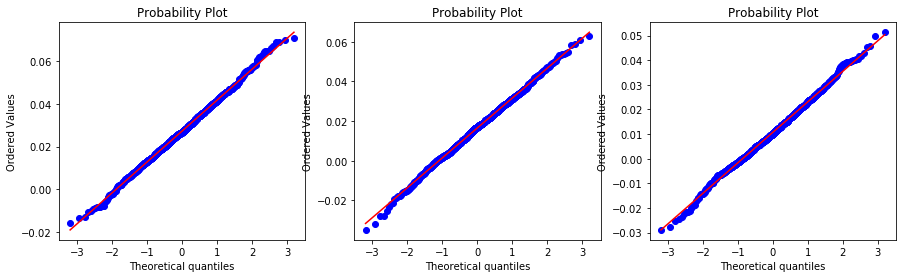

In [8]:
fig = plt.figure(figsize=(15,4))

ax = fig.add_subplot(131)
ax.set_title('Logistic Regression')
scipy.stats.probplot(delta_f1_scores_lr_xgb, dist = "norm", plot=ax)

ax = fig.add_subplot(132)
scipy.stats.probplot(delta_f1_scores_lr_rnn, dist = "norm", plot=ax)

ax = fig.add_subplot(133)
scipy.stats.probplot(delta_f1_scores_rnn_xgb, dist = "norm", plot=ax)

plt.show()

**Вывод:** Визуально все три распределения не сильно отличаются от нормального.

Попробуем формально проверить на нормальность с помощью критерия Шапиро-Уилка.

In [9]:
s, p = scipy.stats.shapiro(delta_f1_scores_lr_xgb)
print("LR + XGBoost statistic: {0}, p-value: {1}".format(s, p))
s, p = scipy.stats.shapiro(delta_f1_scores_lr_rnn)
print("LR + RNN statistic: {0}, p-value: {1}".format(s, p))
s, p = scipy.stats.shapiro(delta_f1_scores_rnn_xgb)
print("RNN + XGBoost statistic: {0}, p-value: {1}".format(s, p))

LR + XGBoost statistic: 0.9984460473060608, p-value: 0.5198925137519836
LR + RNN statistic: 0.9988933205604553, p-value: 0.8133946061134338
RNN + XGBoost statistic: 0.997575044631958, p-value: 0.14636266231536865


**Вывод:** Тест Шапиро-Уилка не отвергает $H_0$ о том, что случайные величины распределены нормально.

In [10]:
def calc_one_sided_alternative(t_stat, p_value, alternative='greater'):
    assert alternative=='greater' or alternative=='less'
    assert p_value >= 0

    if (p_value/2 < 0.05) and (alternative == 'greater' and t_stat > 0) or (alternative == 'less' and t_stat < 0):
         print('Нулевую гипотезу можно отвергнуть в пользу альтернативы с p-value=0.05')
    else:
        print('Нулевую гипотезу нельзя отвергнуть в пользу альтернативы')

Так как выборки взяты из трех нормальных распределений можно сформулировать гипотезы и воспользоваться критерием Стьюдента для связанных выборок.

Выдвенем три гипотезы, которые попарно сравнивают все три классфификатора

$H_0\colon$ среднее значение RNN классификатора больше или равно, чем среднее значение XGB классфикатора $\mu(f1_{rnn}) \geq \mu(f1_{xgb})$

$H_1\colon$ не больше

In [11]:
t, p = scipy.stats.ttest_rel(f1_rnn, f1_xgb)
print(t, p)

calc_one_sided_alternative(t, p, alternative='less')

-27.36584571268203 1.709031590538288e-123
Нулевую гипотезу можно отвергнуть в пользу альтернативы с p-value=0.05


$H_0\colon$ среднее значение LR классификатора больше или равно, чем среднее значение RNN классфикатора $\mu(f1_{lr}) \geq \mu(f1_{rnn})$

$H_1\colon$ не больше

In [12]:
t, p = scipy.stats.ttest_rel(f1_lr, f1_rnn)
print(t, p)

calc_one_sided_alternative(t, p, alternative='less')

-34.86372037206889 7.108354085887873e-175
Нулевую гипотезу можно отвергнуть в пользу альтернативы с p-value=0.05


$H_0\colon$ среднее значение LR классификатора больше, чем среднее значение XGB классфикатора $\mu(f1_{lr}) \geq \mu(f1_{xgb})$

$H_1\colon$ не больше

In [13]:
t, p = scipy.stats.ttest_rel(f1_lr, f1_xgb)
print(t, p)

calc_one_sided_alternative(t, p, alternative='less')

-59.55744251849586 0.0
Нулевую гипотезу можно отвергнуть в пользу альтернативы с p-value=0.05


**Вывод:**

Все три нулевых гипотезы отвергнуты, а это значит что $\mu(f1_{lr}) < \mu(f1_{rnn}) < \mu(f1_{xgb})$.
Значит мы можем выбрать классификатор, построенный на градиентном бустинге в качестве кандидата номер 1, чтобы отправить его в production.